Some NLP tasks :

 - “What’s the topic of this text?” (text classification)
 - “Does this text contain abuse?” (content filtering)
 - “Does this text sound positive or negative?” (sentiment analysis)
 - “What should be the next word in this incomplete sentence?” (language modeling)
 - “How would you say this in German?” (translation)
 - “How would you summarize this article in one paragraph?” (summarization)

Of course, keep in mind throughout this chapter that the text-processing models you
will train won’t possess a human-like understanding of language; rather, they simply
look for statistical regularities in their input data, which turns out to be sufficient to
perform well on many simple tasks. In much the same way that computer vision is pat-
tern recognition applied to pixels, NLP is pattern recognition applied to words, sen-
tences, and paragraphs.

## Preparing text data


Deep learning models, being differentiable functions, can only process numeric ten-
sors: they can’t take raw text as input. Vectorizing text is the process of transforming
text into numeric tensors. Text vectorization processes come in many shapes and
forms, but they all follow the same template :

 - First, you standardize the text to make it easier to process, such as by converting
it to lowercase or removing punctuation.
 - You split the text into units (called tokens), such as characters, words, or groups
of words. This is called tokenization.
 -  You convert each such token into a numeric

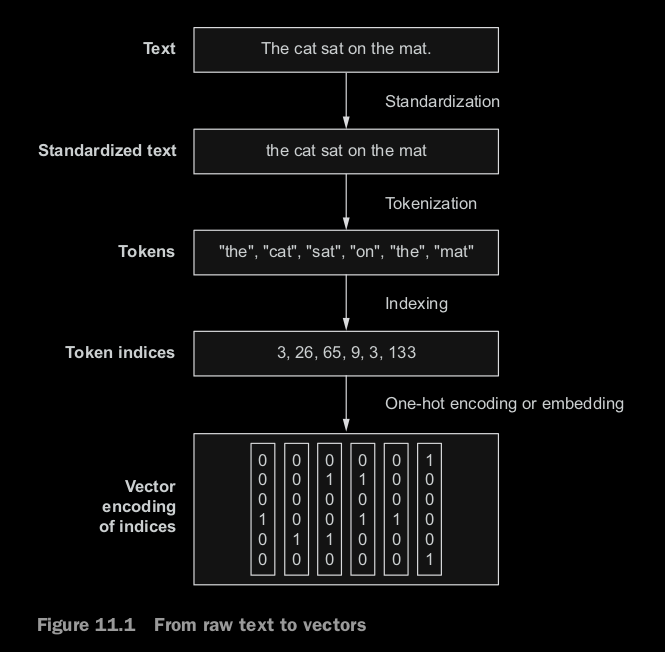

### Text standardization




Consider these two sentences:

 - “sunset came. i was staring at the Mexico sky. Isnt nature splendid??”
 - “Sunset came; I stared at the México sky. Isn’t nature splendid?”

 Text standardization is a basic form of feature engineering that aims to erase
encoding differences that you don’t want your model to have to deal with. It’s not
exclusive to machine learning, either—you’d have to do the same thing if you were
building a search engine.


 - One of the simplest and most widespread standardization schemes is “convert to
lowercase and remove punctuation characters.” Our two sentences would become :   
  - “sunset came i was staring at the mexico sky isnt nature splendid”
  - “sunset came i stared at the méxico sky isnt nature splendid”


 - Another common transformation is to convert special characters
to a standard form, such as replacing “é” with “e,” “æ” with “ae,” and so on. Our token
“méxico” would then become “mexico”.


 - Lastly, a much more advanced standardization pattern that is more rarely used in a
machine learning context is stemming: converting variations of a term (such as differ-
ent conjugated forms of a verb) into a single shared representation, like turning
“caught” and “been catching” into “[catch]” or “cats” into “[cat]”. With stemming,
“was staring” and “stared” would become something like “[stare]”, and our two similar
sentences would finally end up with an identical encoding:
  - “sunset came i [stare] at the mexico sky isnt nature splendid”

Of course, standardization may
also erase some amount of information, so always keep the context in mind.


### Text splitting (tokenization)



Once your text is standardized, you need to break it up into units to be vectorized
(tokens), a step called tokenization. You could do this in three different ways:

 - Word-level tokenization —Where tokens are space-separated (or punctuation-
separated) substrings. A variant of this is to further split words into subwords
when applicable—for instance, treating “staring” as “star+ing” or “called” as
“call+ed.”
 - N-gram tokenization—Where tokens are groups of N consecutive words. For
instance, “the cat” or “he was” would be 2-gram tokens (also called bigrams).
 - Character-level tokenization—Where each character is its own token. In practice,
this scheme is rarely used, and you only really see it in specialized contexts, like
text generation or speech recognition.


There are two
kinds of text-processing models: those that care about word order, called **sequence models,** and those that treat input words as a set, discarding their original order, called
**bag-of-words models**. If you’re building a **sequence model**, you’ll use word-level tokeni-
zation, and if you’re building a **bag-of-words model**, you’ll use N-gram tokenization.

### Vocabulary Indexing



Once your text is split into tokens, you need to encode each token into a numerical
representation.


the way you’d go about it is to build
an index of all terms found in the training data (the “vocabulary”), and assign a
unique integer to each entry in the vocabulary.

Something like this:
```python

vocabulary = {}
for text in dataset:
  text = standardize(text)
  tokens = tokenize(text)
  for token in tokens:
    if token not in vocabulary:
      vocabulary[token] = len(vocabulary)
```

You can then convert that integer into a vector encoding that can be processed by a
neural network, like a one-hot vector:

```python
def one_hot_encode_token(token):
  vector = np.zeros((len(vocabulary),))
  token_index = vocabulary[token]
  vector[token_index] = 1
  return vector
```


Note that at this step it’s common to restrict the vocabulary to only the top 20,000 or
30,000 most common words found in the training data. Any text dataset tends to fea-
ture an extremely large number of unique terms, most of which only show up once or
twice—indexing those rare terms would result in an excessively large feature space,
where most features would have almost no information content.

<br>

Your training
data may not have contained any instance of the word “cherimoya” (or maybe you
excluded it from your index because it was too rare), so doing token_index =
vocabulary["cherimoya"] may result in a KeyError. To handle this, you should use
an “out of vocabulary” index (abbreviated as OOV index)—a catch-all for any token
that wasn’t in the index. It’s usually index 1: you’re actually doing  ```token_index = vocabulary.get(token, 1)```. When decoding a sequence of integers back into words,
you’ll replace 1 with something like “[UNK]” (which you’d call an “OOV token”).



There are
two special tokens that you will commonly use: the OOV token (index 1), and the
mask token (index 0).


the mask token tells us “ignore me, I’m not a word.” You’d use it in particular to
pad sequence data: because data batches need to be contiguous, all sequences in a
batch of sequence data must have the same length, so shorter sequences should be
padded to the length of the longest sequence. If you want to make a batch of data with
the sequences [5, 7, 124, 4, 89] and [8, 34, 21], it would have to look like this:
```python
[[5, 7, 124, 4, 89]
[8, 34, 21, 0, 0]]
```

### Using the TextVectorization layer

#### Python Scratch implementation

In [ ]:
import string 

class Vectorizer:
  def standardize(self, text):
    # turn text to lower and remove puctuations
    text = text.lower()
    return "".join(char for char in text if char not in string.punctuation)

  def tokenize(self, text):
    # retrun a list of word-level tokenized words
    text = self.standardize(text)
    return text.split()

  def make_vocabulary(self, dataset):
    # add token to vacabulary 
    self.vocabulary = {"":0 , "[UNK]" : 1}
    for text in dataset:
      text = self.standardize(text)
      tokens = self.tokenize(text)
      for token in tokens:
        if token not in self.vocabulary:
          self.vocabulary[token] = len(self.vocabulary)

    self.inverse_vocabulary = dict ( (v,k) for k,v in self.vocabulary.items())

  def encode(self, text):
    # encode a token into correspondind vector , 1 if not in vocabulary
    text = self.standardize(text)
    tokens = self.tokenize(text)
    return [self.vocabulary.get(token , 1) for token in tokens]

  def decode(self, int_sequences):
    # decode a sequence to corresponding words , [UNK] if not in vocabulary
    return " ".join(self.inverse_vocabulary.get(i, " [UNK] ") for i in int_sequences)


In [ ]:
vectorizer = Vectorizer()

In [1]:
dataset = [
"I write, erase, rewrite",
"Erase again, and then",
"A poppy blooms.",
]

In [ ]:
vectorizer.make_vocabulary(dataset)

In [ ]:
test_sentence = "I write, rewrite, and still rewrite again"
encoded_sentence = vectorizer.encode(test_sentence)
print(encoded_sentence)

[2, 3, 5, 7, 1, 5, 6]


#### the Keras TextVectorization layer,

In [1]:
from tensorflow.keras.layers import TextVectorization

In [ ]:
text_vecotorization = TextVectorization(output_mode="int")
# configure the layer to return integer indices

By default, the TextVectorization layer will use the setting “convert to lowercase and
remove punctuation” for text standardization, and “split on whitespace” for tokeniza-
tion. But importantly, you can provide custom functions for standardization and toke-
nization, which means the layer is flexible enough to handle any use case.

Note that
such custom functions should operate on tf.string tensors, not regular Python
strings! For instance, the default layer behavior is equivalent to the following:

In [ ]:
import re
import string
import tensorflow as tf

def custom_standardization_fn(string_tensor):
  lowercase_string = tf.strings.lower(string_tensor)
  return tf.strings.regex_replace(lowercase_string, f"[{re.escape(string.punctuation)}]", "")

def custom_split_fn(string_tensor):
  return tf.strings.split(string_tensor)

In [ ]:
text_vectorization = TextVectorization(
    output_mode="int",
    standardize=custom_standardization_fn,
    split=custom_split_fn,
    )

#### Using the TextVectorization layer in a tf.data pipeline or as part of a model

There are two ways we could use our TextVectorization layer. The first option is
to put it in the tf.data pipeline, like this:
```python
int_sequence_dataset = string_dataset.map(
text_vectorization,
num_parallel_calls=4)
```


The second option is to make it part of the model (after all, it’s a Keras layer), like this:
```python
text_input = keras.Input(shape=(), dtype="string")
vectorized_text = text_vectorization(text_input)
embedded_input = keras.layers.Embedding(...)(vectorized_text)
output = ...
model = keras.Model(text_input, output)
```


There’s an important difference between the two: if the vectorization step is part of
the model, it will happen synchronously with the rest of the model. This means that
at each training step, the rest of the model (placed on the GPU) will have to wait for
the output of the TextVectorization layer (placed on the CPU) to be ready in order
to get to work. Meanwhile, putting the layer in the tf.data pipeline enables you to do asynchronous preprocessing of your data on CPU: while the GPU runs the model
on one batch of vectorized data, the CPU stays busy by vectorizing the next batch of
raw strings.


So if you’re training the model on GPU or TPU, you’ll probably want to go with the first
option to get the best performance. This is what we will do in all practical examples
throughout this chapter. When training on a CPU, though, synchronous processing is
fine: you will get 100% utilization of your cores regardless of which option you go with.


Now, if you were to export our model to a production environment, you would want to
ship a model that accepts raw strings as input, like in the code snippet for the second
option above—otherwise you would have to reimplement text standardization and
tokenization in your production environment (maybe in JavaScript?), and you would
face the risk of introducing small preprocessing discrepancies that would hurt the
model’s accuracy. Thankfully, the TextVectorization layer enables you to include
text preprocessing right into your model, making it easier to deploy—even if you were
originally using the layer as part of a tf.data pipeline. In the sidebar “Exporting a
model that processes raw strings,” you’ll learn how to export an inference-only
trained model that incorporates text preprocessing.

## modeling

The problem of order in natural language is an interesting one: unlike the steps of
a timeseries, words in a sentence don’t have a natural, canonical order. Different lan-
guages order similar words in very different ways.

Even within a given language, you
can typically say the same thing in different ways by reshuffling the words a bit. Even
further, if you fully randomize the words in a short sentence, you can still largely fig-
ure out what it was saying—though in many cases significant ambiguity seems to arise.

Order is clearly important, but its relationship to meaning isn’t straightforward.

The simplest thing you could do is just discard order and
treat text as an unordered set of words—this gives you bag-of-words models. You could
also decide that words should be processed strictly in the order in which they appear,
one at a time, like steps in a timeseries.

Finally, a hybrid approach is also possible: the Transformer architecture is technically order-agnostic, yet it injects word-position information into
the representations it processes, which enables it to simultaneously look at different
parts of a sentence (unlike RNNs) while still being order-aware. Because they take into
account word order, both RNNs and Transformers are called sequence models.

### Sequences Models and the IMDB movie reviews data

In [2]:
#Let’s start by downloading the dataset from the Stanford page of Andrew Maas and
#uncompressing it:

!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  31.9M      0  0:00:02  0:00:02 --:--:-- 31.9M


In [3]:
'''
 You’re left with a directory named aclImdb, with the following structure:


aclImdb/
...train/
......pos/
......neg/
...test/
......pos/
......neg/ 


For instance, the train/pos/ directory contains a set of 12,500 text files, each of which
contains the text body of a positive-sentiment movie review to be used as training data.
The negative-sentiment reviews live in the “neg” directories. In total, there are 25,000
text files for training and another 25,000 for testing.
There’s also a train/unsup subdirectory in there, which we don’t need. Let’s

delete it:
'''
!rm -r aclImdb/train/unsup

In [4]:
''' Take a look at the content of a few of these text files. Whether you’re working with
text data or image data, remember to always inspect what your data looks like before
you dive into modeling it. It will ground your intuition about what your model is actu-
ally doing:
 '''
!cat aclImdb/train/pos/4077_10.txt

I first saw this back in the early 90s on UK TV, i did like it then but i missed the chance to tape it, many years passed but the film always stuck with me and i lost hope of seeing it TV again, the main thing that stuck with me was the end, the hole castle part really touched me, its easy to watch, has a great story, great music, the list goes on and on, its OK me saying how good it is but everyone will take there own best bits away with them once they have seen it, yes the animation is top notch and beautiful to watch, it does show its age in a very few parts but that has now become part of it beauty, i am so glad it has came out on DVD as it is one of my top 10 films of all time. Buy it or rent it just see it, best viewing is at night alone with drink and food in reach so you don't have to stop the film.<br /><br />Enjoy

In [5]:
#Next, let’s prepare a validation set by setting apart 20% of the training text files in a
#new directory, aclImdb/val:


import os , pathlib , shutil , random

base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"

for category in ("neg", "pos"):
  os.makedirs(val_dir / category)
  files = os.listdir(train_dir / category)
  random.Random(1337).shuffle(files)
  num_val_samples = int(0.2 * len(files))
  val_files = files[-num_val_samples:]
  for fname in val_files:
    shutil.move(train_dir / category / fname ,
                val_dir / category /fname)



In [6]:
#Let’s create three Dataset objects for training, validation, and testing:


from tensorflow import keras
batch_size = 32 

train_ds = keras.utils.text_dataset_from_directory(
"aclImdb/train", batch_size=batch_size )

val_ds = keras.utils.text_dataset_from_directory(
"aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
"aclImdb/test", batch_size=batch_size
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [7]:
for inputs , targets in train_ds:
  print("Input shape :", inputs.shape)
  print("inputs.dtype:", inputs.dtype)
  print("targets.shape:", targets.shape)
  print("targets.dtype:", targets.dtype)
  print("inputs[0]:", inputs[0])
  print("targets[0]:", targets[0])
  break

Input shape : (32,)
inputs.dtype: <dtype: 'string'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor(b'In late 1800s San Francisco, poor well-dressed Errol Flynn (as James J. Corbett) works at a bank, and enjoys attending local "fights" (boxing) with co-worker and drinking buddy Jack Carson (as Walter Lowrie). One day, pretty Alexis Smith (as Victoria Ware) walks into the "Comstock Bank", where Mr. Flynn works. Flynn is so taken with Ms. Smith\'s elegant beauty, he offers to carry her withdrawal purse. Smith is secretly taken with the handsome Flynn, but is put off by his brashness.<br /><br />Flynn\'s good deed (actually, pick-up attempt) gets him a complimentary membership in the snooty "Olympic Club", which conveniently includes a gymnasium (with boxing equipment). However, Flynn\'s presumptuous manner, and practical joking (he tickles men on the parallel bars) irritates "Club" members. When an English boxing champ visits the club, members endeavor to get Fl

### Processing words as a set: The bag-of-words approach


The simplest way to encode a piece of text for processing by a machine learning
model is to discard order and treat it as a set (a “bag”) of tokens. You could either look
at individual words (unigrams), or try to recover some local order information by
looking at groups of consecutive token (N-grams).




#### SINGLE WORDS (UNIGRAMS) WITH BINARY ENCODING


If you use a bag of single words, the sentence “the cat sat on the mat” becomes :     

_{"cat", "mat", "on", "sat", "the"}_


The main advantage of this encoding is that you can represent an entire text as a single vector, where each entry is a presence indicator for a given word.

 For instance,
using binary encoding (multi-hot), you’d encode a text as a vector with as many
dimensions as there are words in your vocabulary—with 0s almost everywhere and
some 1s for dimensions that encode words present in the text.

In [ ]:
''' First, let’s process our raw text datasets with a TextVectorization layer so that
they yield multi-hot encoded binary word vectors. Our layer will only look at single
words (that is to say, unigrams). 
'''



In [9]:
text_vectorization = TextVectorization(
    max_tokens=20000,
    output_mode = "multi_hot",
)

text_only_train_ds = train_ds.map(lambda x, y :x) 
text_vectorization.adapt(text_only_train_ds)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [10]:
''' Prepare processed
versions of our training,
validation, and test
dataset.
Make sure to specify
num_parallel_calls to
leverage multiple CPU
cores.
 '''

binary_1gram_train_ds = train_ds.map(
  lambda x, y: (text_vectorization(x), y),
  num_parallel_calls=4)

binary_1gram_val_ds = val_ds.map(
  lambda x, y: (text_vectorization(x), y),
  num_parallel_calls=4)

binary_1gram_test_ds = test_ds.map(
  lambda x, y: (text_vectorization(x), y),
  num_parallel_calls=4)

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(max_tokens=20000, hidden_dim=16):
  #tf.keras.backend.clear_session()
  inputs = keras.Input(shape=(max_tokens,))
  x = layers.Dense(hidden_dim, activation="relu")(inputs)
  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(1, activation="sigmoid")(x)

  model = keras.Model(inputs, outputs)

  model.compile(optimizer="rmsprop",
      loss="binary_crossentropy",
      metrics=["accuracy"])
  
  return model

In [12]:
model = get_model()
model.summary()
callbacks = [ keras.callbacks.ModelCheckpoint("binary_1gram.keras", save_best_only=True)]

#We call cache() on the datasets to cache them in memory , the preprocessing will be did during the first epoch and we will reuse the 
#preprocessed text for the following epochs 


model.fit(binary_1gram_train_ds.cache(),
          validation_data=binary_1gram_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense (Dense)               (None, 16)                320016    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 11s 17ms/step - loss: 0.4031 - accuracy: 0.8294 - val_loss: 0.2986 - val_accuracy: 0.8850
Epoch 2/10
625/625 [=======================

In [13]:
model = keras.models.load_model("binary_1gram.keras")
print(f"Test acc: {model.evaluate(binary_1gram_test_ds)[1]:.3f}")

782/782 [==============================] - 6s 8ms/step - loss: 0.2917 - accuracy: 0.8831
Test acc: 0.883


#### BIGRAMS WITH BINARY ENCODING

Of course, discarding word order is very reductive, because even atomic concepts can
be expressed via multiple words: the term “United States” conveys a concept that is
quite distinct from the meaning of the words “states” and “united” taken separately.
For this reason, you will usually end up re-injecting local order information into your
bag-of-words representation by looking at N-grams rather than single words (most
commonly, bigrams).

With bigrams, our sentence becomes :
```
{"the", "the cat", "cat", "cat sat", "sat",
"sat on", "on", "on the", "the mat", "mat"}
```

In [14]:
# Configuring the TextVectorization layer to return bigrams

text_vectorization =  TextVectorization(
    ngrams = 2,
    max_tokens = 20000,
    output_mode = "multi_hot"
)

In [15]:
# Training and testing the binary bigram model

text_vectorization.adapt(text_only_train_ds)

binary_2gram_train_ds = train_ds.map(
  lambda x, y: (text_vectorization(x), y),
  num_parallel_calls=4)

binary_2gram_val_ds = val_ds.map(
  lambda x, y: (text_vectorization(x), y),
  num_parallel_calls=4)

binary_2gram_test_ds = test_ds.map(
  lambda x, y: (text_vectorization(x), y),
  num_parallel_calls=4)

In [16]:
model = get_model()
model.summary()

callbacks = [
keras.callbacks.ModelCheckpoint("binary_2gram.keras",
      save_best_only=True)
                ]


model.fit(binary_2gram_train_ds.cache(),
    validation_data=binary_2gram_val_ds.cache(),
    epochs=10,
        callbacks=callbacks)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_2 (Dense)             (None, 16)                320016    
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 11s 17ms/step - loss: 0.3701 - accuracy: 0.8443 - val_loss: 0.2705 - val_accuracy: 0.9000
Epoch 2/10
625/625 [=====================

In [17]:
model = keras.models.load_model("binary_2gram.keras")
print(f"Test acc: {model.evaluate(binary_2gram_test_ds)[1]:.3f}")

782/782 [==============================] - 7s 9ms/step - loss: 0.2667 - accuracy: 0.8999
Test acc: 0.900


#### BIGRAMS WITH TF-IDF ENCODING

You can also add a bit more information to this representation by counting how many
times each word or N-gram occurs, that is to say, by taking the histogram of the words
over the text:

```
{"the": 2, "the cat": 1, "cat": 1, "cat sat": 1, "sat": 1,
"sat on": 1, "on": 1, "on the": 1, "the mat: 1", "mat": 1}
```

In [18]:
# Configuring the TextVectorization layer to return token counts

text_vectorization = TextVectorization(
  ngrams=2,
  max_tokens=20000,
  output_mode="count"
)



some common words (like "the," "a," "is," and "are") dominating word counts in NLP tasks. These words are not very useful for classification purposes, but they show up frequently in texts, which can make it difficult to identify the most informative words for classification.

To address this issue, we can apply a normalization scheme called TF-IDF, which stands for "term frequency, inverse document frequency." This normalization scheme considers the frequency of a term in a document and how often it appears in other documents. By dividing the term frequency by the inverse document frequency, TF-IDF gives more weight to words that appear frequently in one document but not in many others, and less weight to words that appear frequently across all documents. This helps to identify the most informative words for classification purposes, regardless of how common or rare they are in the text.

In [19]:
# Understanding TF-IDF normalization

''' The more a given term appears in a document, the more important that term is for
understanding what the document is about. At the same time, the frequency at which
the term appears across all documents in your dataset matters too: terms that
appear in almost every document (like “the” or “a”) aren’t particularly informative,
while terms that appear only in a small subset of all texts (like “Herzog”) are very dis-
tinctive, and thus important. TF-IDF is a metric that fuses these two ideas. It weights
a given term by taking “term frequency,” how many times the term appears in the
current document, and dividing it by a measure of “document frequency,” which esti-
mates how often the term comes up across the dataset. You’d compute it as follows: '''

def tfidf(term, document, dataset):
  term_freq = document.count(term)
  doc_freq = math.log(sum(doc.count(term) for doc in dataset) + 1)
  return term_freq / doc_freq

In [20]:
# Configuring TextVectorization to return TF-IDF-weighted outputs

text_vectorization = TextVectorization(
    ngrams=2,
    max_tokens=20000,
    output_mode="tf_idf",
)

In [21]:
# Training and testing the TF-IDF bigram model

text_vectorization.adapt(text_only_train_ds)

tfidf_2gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)


tfidf_2gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)


tfidf_2gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

In [22]:
model = get_model()
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("tfidf_2gram.keras",
    save_best_only=True)
    ]


model.fit(tfidf_2gram_train_ds.cache(),
      validation_data=tfidf_2gram_val_ds.cache(),
      epochs=10,
        callbacks=callbacks)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_4 (Dense)             (None, 16)                320016    
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 12s 17ms/step - loss: 0.5380 - accuracy: 0.7699 - val_loss: 0.3235 - val_accuracy: 0.8812
Epoch 2/10
625/625 [=====================

In [23]:
model = keras.models.load_model("tfidf_2gram.keras")
print(f"Test acc: {model.evaluate(tfidf_2gram_test_ds)[1]:.3f}")

782/782 [==============================] - 7s 9ms/step - loss: 0.3095 - accuracy: 0.8817
Test acc: 0.882


#### Exporting a model that processes raw strings

In the preceding examples, we did our text standardization, splitting, and indexing as
part of the tf.data pipeline. But if we want to export a standalone model indepen-
dent of this pipeline, we should make sure that it incorporates its own text prepro-
cessing (otherwise, you’d have to reimplement in the production environment, which
can be challenging or can lead to subtle discrepancies between the training data and
the production data). Thankfully, this is easy.

In [25]:
#Just create a new model that reuses your TextVectorization layer and adds to it
#the model you just trained:

inputs = keras.Input(shape=(1,), dtype="string")
# apply text preprocessing
processed_inputs = text_vectorization(inputs)
# apply the previously trained model
outputs = model(processed_inputs)
#instantiate a end-to-end model
inference_model = keras.Model(inputs, outputs)

In [27]:
# The resulting model can process batches of raw strings:
import tensorflow as tf
raw_text_data = tf.convert_to_tensor([
    ["That was an excellent movie, I loved it."],
])

predictions = inference_model(raw_text_data)
print(f"{float(predictions[0] * 100):.2f} percent positive")

95.63 percent positive


### Processing words as a sequence: The sequence model approach
the
history of deep learning is that of a move away from manual feature engineering, toward
letting models learn their own features from exposure to data alone. What if, instead of
manually crafting order-based features, we exposed the model to raw word sequences
and let it figure out such features on its own? This is what sequence models are about.



To implement a sequence model, you’d start by representing your input samples as
sequences of integer indices (one integer standing for one word). Then, you’d map
each integer to a vector to obtain vector sequences. Finally, you’d feed these
sequences of vectors into a stack of layers that could cross-correlate features from adja-
cent vectors, such as a 1D convnet, a RNN, or a Transformer.

#### A FIRST PRACTICAL EXAMPLE

Let’s try out a first sequence model in practice. First, let’s prepare datasets that return
integer sequences.

In [10]:
# Preparing integer sequence dataset
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers 

max_length = 600
max_tokens = 20000

text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)

In [11]:
text_vectorization.adapt(text_only_train_ds)


int_train_ds = train_ds.map(
lambda x, y: (text_vectorization(x), y),
num_parallel_calls=4)

int_val_ds = val_ds.map(
lambda x, y: (text_vectorization(x), y),
num_parallel_calls=4)

int_test_ds = test_ds.map(
lambda x, y: (text_vectorization(x), y),
num_parallel_calls=4)

In [12]:
''' Next, let’s make a model. The simplest way to convert our integer sequences to vector
sequences is to one-hot encode the integers (each dimension would represent one
possible term in the vocabulary). On top of these one-hot vectors, we’ll add a simple
bidirectional LSTM. '''

# A sequence model built on one-hot encoded vector sequences

inputs = keras.Input(shape=(None,), dtype="int64")
embedded = tf.one_hot(inputs, depth=max_tokens)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"])


model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, None, 20000)       0         
                                                                 
 bidirectional (Bidirectiona  (None, 64)               5128448   
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 5,128,513
Trainable params: 5,128,513
Non-trainable params: 0
___________________________________________________

In [ ]:
# Training a first basic sequence model

callbacks = [
keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras",
save_best_only=True)]

model.fit(int_train_ds, validation_data=int_val_ds, epochs=10,callbacks=callbacks)

This dataset is very heavy , its a matrix of shape(600,20000), the training will be very slow and RAM expensive , and the accuracy will be around only 87%, on low GPU-RAM machine , it's clearly don't worth it , another approach , more accurate and less expensive is **word embedding**

#### UNDERSTANDING WORD EMBEDDINGS

Word embeddings are vector representations of words that achieve exactly this: they
map human language into a structured geometric space.

Besides being dense representations, word embeddings are also structured representa-
tions, and their structure is learned from data. Similar words get embedded in close
locations, and further, specific directions in the embedding space are meaningful. To
make this clearer, let’s look at a concrete example.


In figure 11.3, four words are embedded on a 2D plane: cat, dog, wolf, and tiger.
With the vector representations we chose here, some semantic relationships between
these words can be encoded as geometric transformations. For instance, the same
vector allows us to go from cat to tiger and from dog to wolf: this vector could be inter-
preted as the “from pet to wild animal” vector. Similarly, another vector lets us go
from dog to cat and from wolf to tiger, which could be interpreted as a “from canine
to feline” vector.

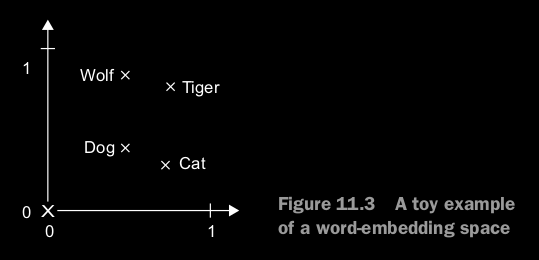


There are two ways
to obtain word embeddings: 

 - Learn word embeddings jointly with the main task you care about (such as doc-
ument classification or sentiment prediction). In this setup, you start with ran-
dom word vectors and then learn word vectors in the same way you learn the
weights of a neural network.

 - Load into your model word embeddings that were precomputed using a differ-
ent machine learning task than the one you’re trying to solve. These are called
pretrained word embeddings.

#### LEARNING WORD EMBEDDINGS WITH THE EMBEDDING LAYER

Thre's not a word-embdedding space that would perfectly map human language, ther are many different languages and they are not isophonic to one another.


But
more pragmatically, what makes a good word-embedding space depends heavily on
your task: the perfect word-embedding space for an English-language movie-review
sentiment-analysis model may look different from the perfect embedding space for an
English-language legal-document classification model, because the importance of cer-
tain semantic relationships varies from task to task.

In [14]:
# Instantiating an Embedding layer

embedding_layer = layers.Embedding(input_dim=max_tokens, output_dim=256)

#The Embedding layer takes at least two arguments: the number of
#possible tokens and the dimensionality of the embeddings (here, 256).

The Embedding layer is best understood as a dictionary that maps integer indices
(which stand for specific words) to dense vectors. It takes integers as input, looks up
these integers in an internal dictionary, and returns the associated vectors. It’s effectively a dictionary lookup .



The Embedding layer takes as input a rank-2 tensor of integers, of shape (batch_size,
sequence_length), where each entry is a sequence of integers. The layer then returns
a 3D floating-point tensor of shape (batch_size, sequence_length, embedding_
dimensionality)




In [18]:
# Model that uses an Embedding layer trained from scratch

inputs = keras.Input(shape=(None,), dtype="int64")

embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=["accuracy"])

callbacks = [
keras.callbacks.ModelCheckpoint("embeddings_bidir_gru.keras",
save_best_only=True)
]

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 256)         5120000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               73984     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,194,049
Trainable params: 5,194,049
Non-trainable params: 0
_________________________________________________

In [19]:
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10,callbacks=callbacks)

Epoch 1/10
625/625 [==============================] - 61s 92ms/step - loss: 0.5325 - accuracy: 0.7254 - val_loss: 0.4275 - val_accuracy: 0.8304
Epoch 2/10
625/625 [==============================] - 38s 61ms/step - loss: 0.3450 - accuracy: 0.8684 - val_loss: 0.3346 - val_accuracy: 0.8668
Epoch 3/10
625/625 [==============================] - 32s 51ms/step - loss: 0.2735 - accuracy: 0.9015 - val_loss: 0.3445 - val_accuracy: 0.8692
Epoch 4/10
625/625 [==============================] - 28s 44ms/step - loss: 0.2355 - accuracy: 0.9185 - val_loss: 0.3566 - val_accuracy: 0.8710
Epoch 5/10
625/625 [==============================] - 28s 44ms/step - loss: 0.1956 - accuracy: 0.9337 - val_loss: 0.4083 - val_accuracy: 0.8682
Epoch 6/10
625/625 [==============================] - 26s 42ms/step - loss: 0.1724 - accuracy: 0.9431 - val_loss: 0.3898 - val_accuracy: 0.8766
Epoch 7/10
625/625 [==============================] - 27s 42ms/step - loss: 0.1498 - accuracy: 0.9525 - val_loss: 0.3998 - val_accuracy:

In [20]:
model = keras.models.load_model("embeddings_bidir_gru.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

782/782 [==============================] - 14s 16ms/step - loss: 0.3459 - accuracy: 0.8560
Test acc: 0.856


#### UNDERSTANDING PADDING AND MASKING


One thing that’s slightly hurting model performance here is that our input sequences
are full of zeros. This comes from our use of the output_sequence_length=max_
length option in TextVectorization (with max_length equal to 600): sentences lon-
ger than 600 tokens are truncated to a length of 600 tokens, and sentences shorter
than 600 tokens are padded with zeros at the end so that they can be concatenated
together with other sequences to form contiguous batches.

We’re using a bidirectional RNN: two RNN layers running in parallel, with one
processing the tokens in their natural order, and the other processing the same
tokens in reverse. The RNN that looks at the tokens in their natural order will spend
its last iterations seeing only vectors that encode padding—possibly for several hun-
dreds of iterations if the original sentence was short. The information stored in the
internal state of the RNN will gradually fade out as it gets exposed to these meaning-
less inputs.
We need some way to tell the RNN that it should skip these iterations. There’s an
API for that: masking.
The Embedding layer is capable of generating a “mask” that corresponds to its
input data. This mask is a tensor of ones and zeros (or True/False booleans), of shape
(batch_size, sequence_length), where the entry mask[i, t] indicates where time-
step t of sample i should be skipped or not (the timestep will be skipped if mask[i, t]
is 0 or False, and processed otherwise).

In [23]:
from keras.layers import Embedding
embedding_layer = Embedding(input_dim=10, output_dim=256, mask_zero=True)

In [24]:
some_input = [
[4, 3, 2, 1, 0, 0, 0],
[5, 4, 3, 2, 1, 0, 0],
[2, 1, 0, 0, 0, 0, 0]]

mask = embedding_layer.compute_mask(some_input)

In [26]:
mask

<tf.Tensor: shape=(3, 7), dtype=bool, numpy=
array([[ True,  True,  True,  True, False, False, False],
       [ True,  True,  True,  True,  True, False, False],
       [ True,  True, False, False, False, False, False]])>

In [27]:
# Using an Embedding layer with masking enabled

inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(
input_dim=max_tokens, output_dim=256, mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=["accuracy"])

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_4 (Embedding)     (None, None, 256)         5120000   
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               73984     
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,194,049
Trainable params: 5,194,049
Non-trainable params: 0
_________________________________________________

In [28]:
callbacks = [keras.callbacks.ModelCheckpoint("embeddings_bidir_gru_with_masking.keras",save_best_only=True)]

model.fit(int_train_ds, validation_data=int_val_ds, epochs=10,callbacks=callbacks)

Epoch 1/10
625/625 [==============================] - 78s 113ms/step - loss: 0.4370 - accuracy: 0.7865 - val_loss: 0.3578 - val_accuracy: 0.8572
Epoch 2/10
625/625 [==============================] - 43s 69ms/step - loss: 0.2753 - accuracy: 0.8919 - val_loss: 0.3259 - val_accuracy: 0.8670
Epoch 3/10
625/625 [==============================] - 36s 58ms/step - loss: 0.2042 - accuracy: 0.9230 - val_loss: 0.3149 - val_accuracy: 0.8814
Epoch 4/10
625/625 [==============================] - 33s 53ms/step - loss: 0.1601 - accuracy: 0.9448 - val_loss: 0.3748 - val_accuracy: 0.8618
Epoch 5/10
625/625 [==============================] - 32s 51ms/step - loss: 0.1228 - accuracy: 0.9582 - val_loss: 0.3870 - val_accuracy: 0.8762
Epoch 6/10
625/625 [==============================] - 33s 53ms/step - loss: 0.0978 - accuracy: 0.9663 - val_loss: 0.3822 - val_accuracy: 0.8750
Epoch 7/10
625/625 [==============================] - 30s 48ms/step - loss: 0.0765 - accuracy: 0.9753 - val_loss: 0.4579 - val_accuracy

In [29]:
model = keras.models.load_model("embeddings_bidir_gru_with_masking.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

782/782 [==============================] - 17s 18ms/step - loss: 0.3200 - accuracy: 0.8745
Test acc: 0.874


#### USING PRETRAINED WORD EMBEDDINGS


Sometimes you have so little training data available that you can’t use your data alone
to learn an appropriate task-specific embedding of your vocabulary. In such cases,
instead of learning word embeddings jointly with the problem you want to solve, you
can load embedding vectors from a precomputed embedding space that you know is
highly structured and exhibits useful properties—one that captures generic aspects of
language structure. The rationale behind using pretrained word embeddings in natu-
ral language processing is much the same as for using pretrained convnets in image
classification: you don’t have enough data available to learn truly powerful features on
your own, but you expect that the features you need are fairly generic—that is, com-
mon visual features or semantic features. In this case, it makes sense to reuse features
learned on a different problem.



There are various precomputed databases of word embeddings that you can down-
load and use in a Keras Embedding layer. Word2vec is one of them. Another popular
one is called Global Vectors for Word Representation [Glove](https://nlp.stanford.edu/projects/glove), which was developed by Stanford researchers in 2014. This
embedding technique is based on factorizing a matrix of word co-occurrence statis-
tics. Its developers have made available precomputed embeddings for millions of
English tokens, obtained from Wikipedia data and Common Crawl data.
Let’s look at how you can get started using GloVe embeddings in a Keras model.
The same method is valid for Word2Vec embeddings or any other word-embedding
database.

In [30]:
''' First, let’s download the GloVe word embeddings precomputed on the 2014
English Wikipedia dataset. It’s an 822 MB zip file containing 100-dimensional embed-
ding vectors for 400,000 words (or non-word tokens). '''


!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2023-03-16 10:41:12--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-03-16 10:41:12--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-03-16 10:41:13--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [31]:
import numpy as np
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}

with open(path_to_glove_file) as f:
  for line in f:
    word, coefs = line.split(maxsplit=1)
    coefs = np.fromstring(coefs, "f", sep=" ")
    embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


In [32]:
# Preparing the GloVe word-embeddings matrix

embedding_dim = 100

vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))


embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
  if i < max_tokens:
    embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector
    

In [33]:
embedding_layer = layers.Embedding(
  max_tokens,
  embedding_dim,
  embeddings_initializer=keras.initializers.Constant(embedding_matrix),
  trainable=False,
  mask_zero=True,
  )

In [34]:
# Model that uses a pretrained Embedding layer

inputs = keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=["accuracy"])

model.summary()

callbacks = [keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.keras",save_best_only=True)]

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_5 (Embedding)     (None, None, 100)         2000000   
                                                                 
 bidirectional_4 (Bidirectio  (None, 64)               34048     
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,034,113
Trainable params: 34,113
Non-trainable params: 2,000,000
____________________________________________

In [35]:
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10,callbacks=callbacks)

Epoch 1/10
625/625 [==============================] - 42s 54ms/step - loss: 0.5793 - accuracy: 0.6900 - val_loss: 0.4760 - val_accuracy: 0.7830
Epoch 2/10
625/625 [==============================] - 30s 48ms/step - loss: 0.4548 - accuracy: 0.7939 - val_loss: 0.4537 - val_accuracy: 0.7898
Epoch 3/10
625/625 [==============================] - 29s 47ms/step - loss: 0.4014 - accuracy: 0.8207 - val_loss: 0.3832 - val_accuracy: 0.8312
Epoch 4/10
625/625 [==============================] - 28s 45ms/step - loss: 0.3704 - accuracy: 0.8382 - val_loss: 0.3687 - val_accuracy: 0.8436
Epoch 5/10
625/625 [==============================] - 27s 43ms/step - loss: 0.3469 - accuracy: 0.8528 - val_loss: 0.3743 - val_accuracy: 0.8444
Epoch 6/10
625/625 [==============================] - 32s 51ms/step - loss: 0.3248 - accuracy: 0.8622 - val_loss: 0.3568 - val_accuracy: 0.8528
Epoch 7/10
625/625 [==============================] - 30s 47ms/step - loss: 0.3071 - accuracy: 0.8703 - val_loss: 0.3319 - val_accuracy: